In [115]:
import matplotlib.pyplot as plt
from IPython.display import Image

import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

from dataset_mod import MyDataset, default_loader
from torch.utils.data import DataLoader
import torchvision
from solver import reconstruction_loss, kl_divergence, to_var
from model import conv_VAE


%load_ext autoreload
%autoreload 2
image_paths = "/Volumes/RCONCI/2 digits fixed offset/test/orig/"
target_paths = "/Volumes/RCONCI/2 digits fixed offset/test/inverse/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
dset = MyDataset
train_data = dset(image_paths,target_paths, image_size= 64)
x, y = train_data.__getitem__(1)

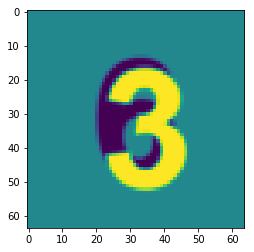

In [74]:
plt.imshow(x[0,:,:])

In [75]:
batch_size= 128
num_workers = 2
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=True,
                          drop_last=False)

In [76]:
vae = conv_VAE(zdims=10)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [137]:
epochs = 60
beta = 1
bs = 128

In [138]:
for epoch in range(epochs):
    for idx, (x, y) in enumerate(train_loader):
        x = to_var(x)
        #x = Variable(cuda(x, self.use_cuda))
        x_recon, mu, logvar = vae(x)
        recon_loss = reconstruction_loss(y, x_recon, 'gaussian')
        total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)
        
        beta_vae_loss = recon_loss + beta*total_kld

        optimizer.zero_grad()
        beta_vae_loss.backward()
        optimizer.step()
        
        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, beta_vae_loss.data[0]/bs))
    
            #recon_x, _, _ = vae(fixed_x)
            #save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), f'reconstructed/recon_image_{epoch}_{idx}.png')

Epoch[1/60] Loss: 0.894
Epoch[2/60] Loss: 0.875
Epoch[3/60] Loss: 0.894
Epoch[4/60] Loss: 0.872
Epoch[5/60] Loss: 0.854
Epoch[6/60] Loss: 0.857
Epoch[7/60] Loss: 0.828
Epoch[8/60] Loss: 0.831
Epoch[9/60] Loss: 0.810
Epoch[10/60] Loss: 0.797
Epoch[11/60] Loss: 0.796
Epoch[12/60] Loss: 0.789
Epoch[13/60] Loss: 0.776
Epoch[14/60] Loss: 0.769
Epoch[15/60] Loss: 0.774
Epoch[16/60] Loss: 0.753
Epoch[17/60] Loss: 0.751
Epoch[18/60] Loss: 0.742
Epoch[19/60] Loss: 0.750
Epoch[20/60] Loss: 0.732
Epoch[21/60] Loss: 0.723
Epoch[22/60] Loss: 0.717
Epoch[23/60] Loss: 0.726
Epoch[24/60] Loss: 0.717
Epoch[25/60] Loss: 0.696
Epoch[26/60] Loss: 0.710
Epoch[27/60] Loss: 0.691
Epoch[28/60] Loss: 0.689
Epoch[29/60] Loss: 0.688
Epoch[30/60] Loss: 0.666
Epoch[31/60] Loss: 0.677
Epoch[32/60] Loss: 0.679
Epoch[33/60] Loss: 0.675
Epoch[34/60] Loss: 0.668
Epoch[35/60] Loss: 0.657
Epoch[36/60] Loss: 0.650
Epoch[37/60] Loss: 0.650
Epoch[38/60] Loss: 0.657
Epoch[39/60] Loss: 0.651
Epoch[40/60] Loss: 0.639
Epoch[41/

In [29]:
import math
math.sqrt(172800/48)

60.0

In [85]:
test_recon.shape

torch.Size([128, 1, 64, 64])

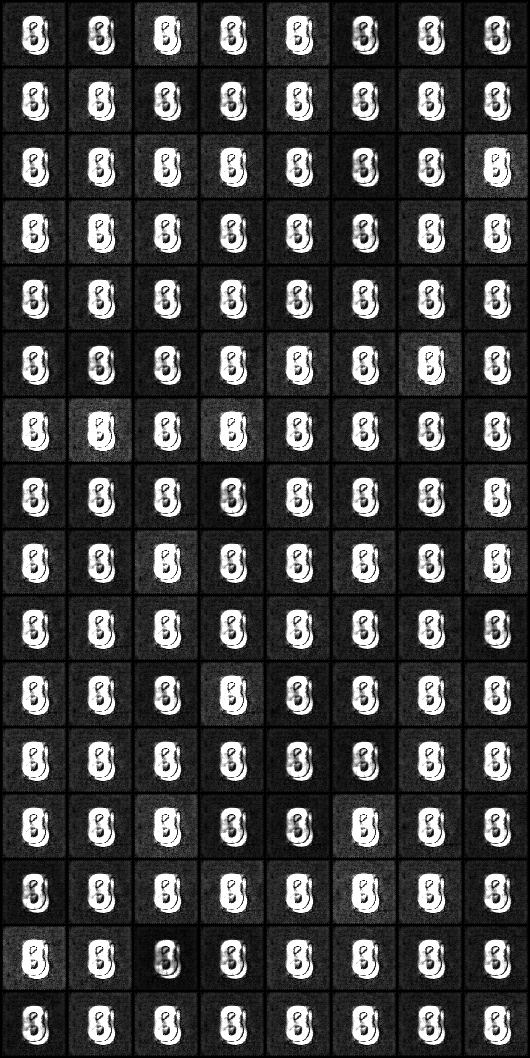

In [139]:
sample = torch.randn(128, 10)
test_recon = vae._decode(sample)
# recon_x, _, _ = vae(fixed_x)
#test_recon= test_recon.detach().numpy()

torchvision.utils.save_image(abs(test_recon.view(test_recon.size(0), 1, 64, 64).data.cpu()), 'sample_image.png')
Image('sample_image.png')

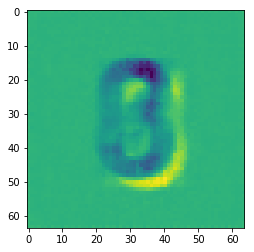

In [149]:
sample = test_recon[0].detach().numpy()
sample = sample + abs(sample.min())
plt.imshow(sample[0,:,:] ) 

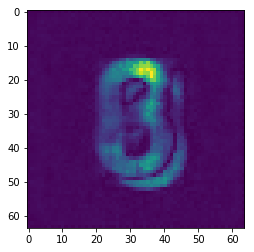

In [160]:
sample = abs(test_recon[0].detach().numpy())
plt.imshow(sample[0,:,:])

In [144]:
sample.max()

2.6983976